In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Calibration
## Preparation of input data
Synthesise LoS columns with optimal paths from the model

In [3]:
input_path = '../input/transport_demand/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Load StepModel with LOS table...
sm = stepmodel.read_json(model_path + 'de_pt_access_egress')
pt = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [6]:
sm.pt_los = pt.pt_los
sm.car_los = car.car_los

In [5]:
# Load calibration dataset
trips = pd.read_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')
print(len(trips.index))

96028


In [6]:
trips = trips.drop(columns='Unnamed: 0')
trips.reset_index(drop=True, inplace=True)
#trips.head()

In [7]:
# Replace LAU codes with NUTS IDs
if not str(trips.loc[0, 'origin']).startswith('DE'):
    z = stepmodel.read_json(model_path + 'de_zones')
    lau_nuts_dict = z.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    trips['origin'] = trips['origin'].astype(str).map(lau_nuts_dict)
    trips['destination'] = trips['destination'].astype(str).map(lau_nuts_dict)

    # Drop all other trips
    trips = trips.loc[(trips['origin'].notna()) & (trips['destination'].notna())]
    len(trips.index)

In [8]:
trips.loc[trips.isna().any(axis=1)]

,origin,destination,SKTYP,distance,distance_routed,duration,purpose,mode,mode_combo,n_persons,...,mode_affinity,dist_train_origin,dist_bus_origin,dist_train_destination,dist_bus_destination,W_DETAIL,W_SO2,urbanisation,purpose_vp,mode_model


In [9]:
len(trips)

95576

## Distance
As survey responds regarding trip distance are not accurate, add the network model's length.

In [10]:
# Add a length column based on the shortest
# road connection in the network model (in km)
car_len = sm.car_los.sort_values('time').groupby(
    ['origin', 'destination']).first()['length'].to_dict()
trips['length'] = [car_len[a]/1000 if a in car_len.keys() else np.nan
                   for a in tuple(zip(trips['origin'], trips['destination']))]

In [11]:
# Some OD pairs might not be in the volumes table
# which results in missing values for the calibration dataset
k = len(trips.loc[trips['length'].isna()])
k / len(trips)

0
0.0


In [12]:
# Drop trips without time reference if its share is insignificant
assert k/len(trips)<0.01
trips = trips.loc[trips['length'].notna()]

<AxesSubplot:xlabel='length', ylabel='distance'>

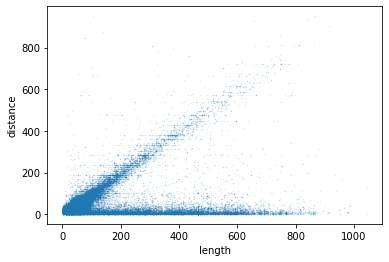

In [13]:
# Comparison of the model's length and the survey's distance
trips.plot.scatter(x='length', y='distance', s=.1, alpha=.2)

In [14]:
# We can validate it with the routed distances from MiD.
bins = [0, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000]
labels = [1,2,3,4,5,6,7,8,9]
trips['length_routed'] = pd.cut(trips['length'], bins=bins, labels=labels)
# How many trips have mismatching routed distances?
len(trips.loc[(trips['distance_routed']!=trips['length_routed'])&(trips['distance_routed']<=9)])

37270

In [15]:
# Check the routed distance in the validation dataset
trips['distance_routed_2'] = pd.cut(trips['distance'], bins=bins, labels=labels)
# How many trips have mismatching routed distances?
len(trips.loc[(trips['distance_routed']!=trips['distance_routed_2'])&(trips['distance_routed']<=9)])

29059

## Time

All imputated time columns are needed for the MLE model. They do not replace duration statements in the survey but complement each trip with alternative travel times in modes that were not used for this trip.

In [16]:
# IMPORTANT: Make sure pt_los time is converted to minutes
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 60
elif sm.pt_los['time'].mean() < 10:
    sm.pt_los['time'] = sm.pt_los['time'] * 60
sm.pt_los['time'].mean()

350.38404505240976

In [17]:
# IMPORTANT: Make sure car_los time is converted to minutes
if sm.car_los['time'].mean() > 3600:
    sm.car_los['time'] = sm.car_los['time'] / 60
elif sm.car_los['time'].mean() < 10:
    sm.car_los['time'] = sm.car_los['time'] * 60
sm.car_los['time'].mean()

270.7570562136326

In [18]:
# Create dictionaries from LoS tables
# Take the mean of 2 fastest trips for PT
car_dict = sm.car_los.sort_values('time').groupby(
    ['origin', 'destination']).first()['time'].to_dict()
pt_dict = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_type']).nth([0,1]).groupby(
    ['origin', 'destination', 'route_type']).agg({'time': 'mean'}).to_dict()['time']

In [19]:
# Car
# Directly from car LoS table
trips['time_car'] = [car_dict[a] if a in car_dict.keys() else np.nan
                     for a in tuple(zip(trips['origin'], trips['destination']))]
assert len(trips.loc[trips['time_car'].isna()])==0

In [20]:
# PT (incl. bicycle)
for t in sm.pt_los['route_type'].unique():
    trips['route_type'] = t
    trips['time_' + t] = [pt_dict[a]
        if a in pt_dict.keys() else np.inf
        for a in tuple(zip(trips['origin'], trips['destination'], trips['route_type']))]
trips.drop('route_type', axis=1, inplace=True)

## Validation of model connectivity

The network model might not provide paths between all OD pairs for all modes. Moreover, the survey might contain erronous statements about trip distance, duration or even origin and destination cell.

In [21]:
# Drop trips where speeds are unrealistic
max_speeds = {1: 150, 2: 200, 3: 50, 4: 100, 5: 1000, 6: 150, 7: 40}
for mode, max_speed in max_speeds.items():
    mask = (trips['mode_model']==mode)&((trips['length']/trips['duration'])>max_speed)
    if manual: print('{}: dropped {} observations ({} %)'.format(
        mode, len(trips.loc[mask]), len(trips.loc[mask])/len(trips.loc[trips['mode_model']==mode])*100))
    trips = trips.loc[~(mask)]

1: dropped 0 observations (0.0 %)
2: dropped 0 observations (0.0 %)
3: dropped 0 observations (0.0 %)
4: dropped 0 observations (0.0 %)
5: dropped 0 observations (0.0 %)
6: dropped 9 observations (0.010817567729993509 %)
7: dropped 18 observations (1.6791044776119404 %)


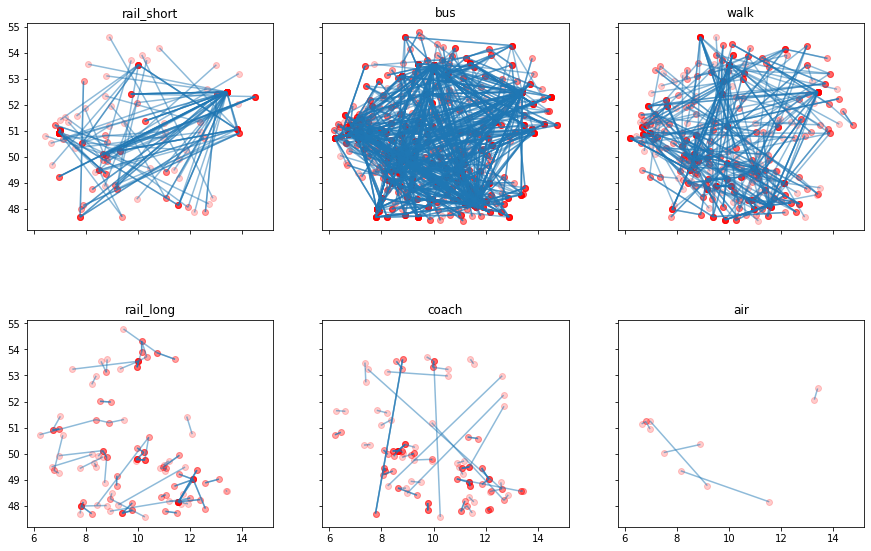

In [22]:
# Check observations without model connection
mode_dict = {1: 'rail_short', 2: 'rail_long',
             3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
fix, axs = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all', figsize=(15,10))
for m, row, col in [(1,0,0), (2,1,0), (3,1,1), (4,0,1), (5,1,2), (7,0,2)]:
    t = trips.loc[((trips['mode_model']==m) & (trips['time_'+mode_dict[m]]==np.inf))]
    lines = gpd.GeoDataFrame({'mode': [m]*len(t),
                              'geometry': [geometry.LineString([sm.centroids.loc[o, 'geometry'].coords[0],
                                                                sm.centroids.loc[d, 'geometry'].coords[0]])
                                           for o,d in zip(t['origin'], t['destination'])]},
                             crs=sm.epsg)
    lines.plot(alpha=.5, ax=gpd.GeoDataFrame(sm.centroids,crs=sm.epsg).loc[
        list(t['origin'])+list(t['destination']), 'geometry'].plot(
            alpha=.2, color='red', ax=axs[row,col]))
    axs[row,col].set_title(mode_dict[m])

In [23]:
# Mean distance of not assigned non-motorised trips
trips.loc[((trips['mode_model']==7) & (trips['time_walk']==np.inf)), 'length'].mean()

267.295611814346

In [24]:
# Mean distance of all non-motorised trips
trips.loc[(trips['mode_model']==7), 'length'].mean()

134.84509392789374

In [25]:
# Assign cycling speed
mask = ((trips['mode_model']==7) & (trips['time_walk']==np.inf))
trips.loc[mask, 'time_walk'] = trips.loc[mask, 'length'] / 17 # km/h

In [26]:
# Aggregate rail
# The fastest route determines time of rail service
trips['time_rail'] = [min(t_s, t_l) for t_s, t_l in zip(
    trips['time_rail_short'], trips['time_rail_long'])]

In [27]:
# Aggregate road PT
trips['time_road'] = [min(t_s, t_l) for t_s, t_l in zip(
    trips['time_bus'], trips['time_coach'])]

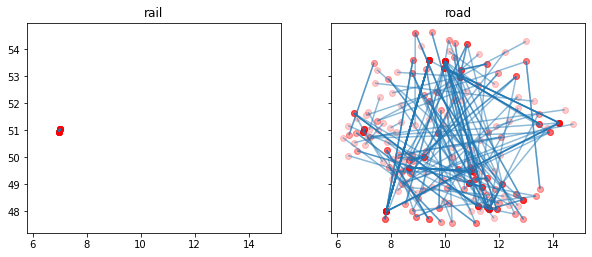

In [28]:
# Check observations without model connection again aggregated
fix, axs = plt.subplots(nrows=1, ncols=2, sharex='all', sharey='all', figsize=(10,5))
for m, modes, row, col in [('rail',[1,2],0,0), ('road',[3,4],0,1)]:
    t = trips.loc[((trips['mode_model'].isin(modes)) & (trips['time_'+m]==np.inf))]
    lines = gpd.GeoDataFrame({'mode': [m]*len(t),
                              'geometry': [geometry.LineString([sm.centroids.loc[o, 'geometry'].coords[0],
                                                                sm.centroids.loc[d, 'geometry'].coords[0]])
                                           for o,d in zip(t['origin'], t['destination'])]},
                             crs=sm.epsg)
    lines.plot(alpha=.5, ax=gpd.GeoDataFrame(sm.centroids,crs=sm.epsg).loc[
        list(t['origin'])+list(t['destination']), 'geometry'].plot(
            alpha=.2, color='red', ax=axs[col]))
    axs[col].set_title(m)

In [29]:
# Mean distance of not assigned road PT trips
trips.loc[((trips['mode_model'].isin([3,4])) & (trips['time_road']==np.inf)), 'length'].mean()

412.60589999999996

In [30]:
# Save missing trips
t = trips.iloc[0:0]
for name, m in [('rail',[1,2]), ('road',[3,4])]:
    t = t.append(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
t.to_csv(input_path + 'missing_trips.csv')

In [31]:
# How many observations have no connection?
m_dict = {v:k for k,v in mode_dict.items()}
for t in m_dict.keys():
    try:
        k = len(trips.loc[((trips['mode_model']==m_dict[t]) & (trips['time_'+t]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            t, k, k/len(trips.loc[trips['mode_model']==m_dict[t]])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(t))

rail_short: 142 observations have no model connection (2.2306000628338043 percent)
rail_long: 95 observations have no model connection (8.683729433272395 percent)
coach: 92 observations have no model connection (35.521235521235525 percent)
bus: 1422 observations have no model connection (40.112834978843445 percent)
air: 6 observations have no model connection (14.285714285714285 percent)
car: 0 observations have no model connection (0.0 percent)
walk: 0 observations have no model connection (0.0 percent)


In [32]:
# How many observations have no connection? (aggregated)
for name, m in {'rail': [1,2], 'road': [3,4], 'air': [5]}.items():
    try:
        k = len(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            name, k, k/len(trips.loc[trips['mode_model'].isin(m)])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(name))

rail: 24 observations have no model connection (0.32171581769436997 percent)
road: 240 observations have no model connection (6.309148264984227 percent)
air: 6 observations have no model connection (14.285714285714285 percent)


In [33]:
# Air trips
len(trips.loc[trips['mode_model']==5])

42

Dropping too high percentage of PT observations will skew the calibration towards the car. Thus, the same share of car, bus, coach trips from the same distance categories should be dropped as well, if the percentage is significant.

In case of public road transport, there might be private charter buses included into the calibration dataset, which cannot be included into the network model. A closer look at missing trips reveals only long-distance travel with purposes shopping or education, which could well be organised shopping trips or class trips, respectively. Thus, we have to drop these trips.

If there are only few missing rail connections, they can be added manually in the mode choice notebook.

Air trips must be replaced, because the survey contains the right proportion of air trips per capita. Dropping them would skew the distribution dramatically because they are so few.

In [34]:
# Drop missing trips
for name, m in {'road': [3,4]}.items():
    trips = trips.loc[~((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))]
trips.shape

(95309, 34)

In [35]:
# Add this rail connection between DEA24 and DEA23 manually
mask = ((trips['mode_model'].isin([1,2])) & (trips['time_rail']==np.inf))
trips.loc[mask, 'time_rail'] = trips.loc[mask, 'duration']
if manual:
    print(trips.loc[mask, 'time_rail'].mean())
    print(trips.loc[mask, 'distance'].mean())

50.875
19.465


In [54]:
# Replace non-existent air connections with model paths
for ind in trips.loc[(trips['mode_model']==5) & (trips['time_air']==np.inf)].index:
    s = sm.pt_los.loc[sm.pt_los['route_type']=='air'].sample()
    o = s['origin'].values[0]
    d = s['destination'].values[0]
    trips.loc[ind, 'origin'] = o
    trips.loc[ind, 'destination'] = d
    trips.loc[ind, 'urbanisation'] = int(sm.centroids.loc[o, 'urbanisation'])
    trips.loc[ind, 'distance'] = s['length'].values[0] / 1000
    trips.loc[ind, 'length'] = s['length'].values[0] / 1000
    trips.loc[ind, 'duration'] = s['time'].values[0] / 60
    trips.loc[ind, 'time_air'] = s['time'].values[0] / 60
    trips.loc[ind, 'time_car'] = car_dict[(o,d)]
    trips.loc[ind, 'time_walk'] = pt_dict[(o,d,'walk')] if (o,d,'walk') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_short'] = pt_dict[(o,d,'rail_short')] if (o,d,'rail_short') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail_long'] = pt_dict[(o,d,'rail_long')] if (o,d,'rail_long') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_bus'] = pt_dict[(o,d,'bus')] if (o,d,'bus') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_coach'] = pt_dict[(o,d,'coach')] if (o,d,'coach') in pt_dict.keys() else np.inf
    trips.loc[ind, 'time_rail'] = min(trips.loc[ind, 'time_rail_short'], trips.loc[ind, 'time_rail_long'])
    trips.loc[ind, 'time_road'] = min(trips.loc[ind, 'time_bus'], trips.loc[ind, 'time_coach'])

In [35]:
'''# Replace observed time for the mode of choice
mode_col_map = {1: 'time_rail_short', 2: 'time_rail_long',
                3: 'time_coach', 4: 'time_bus', 5: 'time_air',
                6: 'time_car', 7: 'time_walk'}
for mode, col in mode_col_map.items():
    mask = (trips['mode_model']==mode)
    trips.loc[mask, col] = trips.loc[mask, 'duration']
trips.loc[trips['mode_model']==1, 'time_rail'] = \
    trips.loc[trips['mode_model']==1, 'time_rail_short']
trips.loc[trips['mode_model']==2, 'time_rail'] = \
    trips.loc[trips['mode_model']==2, 'time_rail_long']
trips.loc[trips['mode_model']==3, 'time_road'] = \
    trips.loc[trips['mode_model']==3, 'time_coach']
trips.loc[trips['mode_model']==4, 'time_road'] = \
    trips.loc[trips['mode_model']==4, 'time_bus']'''
print(' ')

Deprected


In [55]:
trips.replace({np.inf: np.nan}).groupby('mode_model').agg(
    {'time_rail_long': 'mean', 'time_rail_short': 'mean', 'time_rail': 'mean',
     'time_coach': 'mean', 'time_bus': 'mean', 'time_road': 'mean',
     'time_air': 'mean', 'time_car': 'mean', 'time_walk': 'mean'})

,time_rail_long,time_rail_short,time_rail,time_coach,time_bus,time_road,time_air,time_car,time_walk
mode_model,,,,,,,,,
1,112.512534,74.810837,72.627580,150.615094,83.938538,112.178851,256.233876,62.990413,81.333973
2,174.708534,211.027880,163.262127,248.093930,104.198997,236.514388,241.690157,178.026005,95.979710
3,160.929786,133.085586,122.401332,241.359581,83.635863,184.951230,249.859877,116.020697,85.318654
4,160.140432,104.304614,101.226309,219.981260,72.492770,150.821363,244.286092,89.506993,68.781453
5,300.720040,496.324333,300.720040,446.135784,NaN,446.135784,143.747665,375.973413,NaN
6,166.209421,110.121810,105.074014,208.382297,89.398666,147.957552,313.808604,83.254302,85.585069
7,192.364834,128.486486,119.099826,247.208464,72.360928,161.218446,291.335693,106.612160,45.816806


## Price
For model calibration we need cost data for each trip. This column is generated using the travel cost function from the model's LoS formulation. For PT, the type of ticket or subscription is being considered.

In [56]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [57]:
trips['cost_walk'] = 0 # foot and bicycle trips are free of monetary cost

In [58]:
# The same assumptions for car travel as in the car LoS generation (prep30)
vc_car = params['car']['var_cost']
fix_car = params['car']['fix_cost']
parking_cost = params['parking_cost']
trips['cost_car'] = [monetary_cost(d, 1, vc_car, 0,0, parking_cost[u], 1, n) + fix_car * t/60
                     for d, n, u, t in zip(trips['length'], trips['n_persons'],
                                           trips['urbanisation'], trips['duration'])]

In [59]:
# Ticket type determines the trip cost
# Assume this dict with factors
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}

In [60]:
# Rail short-distance, see prep31
# Trips with subscriptions are free of charge
rail_short_slope = params['pt_price']['rail_short_slope']
rail_short_intercept = params['pt_price']['rail_short_intercept']
trips['cost_rail_short'] = [(d*rail_short_slope + rail_short_intercept) * ticket_dict[t]
                            for d, t in zip(trips['length'], trips['ticket_type'])]

In [61]:
# Rail long-distance
# Take prices from the model (validated)
# Choose the fastest routes as reference
rail_dict = sm.pt_los.sort_values('time').loc[
    sm.pt_los['route_type']=='rail_long'
].groupby(['origin', 'destination']).nth([0,1]).groupby(
    ['origin', 'destination']).agg({'price': 'mean'}).to_dict()['price']
trips['cost_rail_long'] = [rail_dict[(o,d)] if (o,d) in rail_dict.keys()
                           else np.inf for o, d in zip(trips['origin'], trips['destination'])]

In [62]:
# How many rail long prices do not exist while short prices do?
len(trips.loc[(trips['cost_rail_long']==np.inf)&(trips['cost_rail_short']!=np.inf)])

47081

In [63]:
# Replace infinite values for rail long with rail short prices
#trips.loc[trips['cost_rail_long']==np.inf, 'cost_rail_long'] = \
#    trips.loc[trips['cost_rail_long']==np.inf, 'cost_rail_short']

In [64]:
# Aggregate rail: Take cost of the alternative that
# has a time closer to the observed time
trips['diff_rail_short'] = (trips['time_rail_short'] - trips['duration']).abs()
trips['diff_rail_long'] = (trips['time_rail_long'] - trips['duration']).abs()
trips['cost_rail'] = [c_l if d_l<d_s else c_s
                      for d_s, d_l, c_s, c_l in zip(
    trips['diff_rail_short'], trips['diff_rail_long'],
    trips['cost_rail_short'], trips['cost_rail_long'])]
trips.drop(['diff_rail_short', 'diff_rail_long'], axis=1, inplace=True)
trips.loc[trips['mode_model']==1, 'cost_rail'] = \
    trips.loc[trips['mode_model']==1, 'cost_rail_short']
trips.loc[trips['mode_model']==2, 'cost_rail'] = \
    trips.loc[trips['mode_model']==2, 'cost_rail_long']

In [65]:
# Add price caps as in prep31
trips['cost_rail'] = np.clip(trips['cost_rail'], 0,
    params['pt_price']['max_rail_long'])
trips['cost_rail_long'] = np.clip(trips['cost_rail_long'],
    params['pt_price']['min_rail_long'],
    params['pt_price']['max_rail_long'])
trips['cost_rail_short'] = np.clip(trips['cost_rail_short'], 0,
    params['pt_price']['max_rail_short'])

In [66]:
# Bus and tram
# Trip cost depend on the ticket type and regional type
# See prep31 for prices
region_prices = {1: params['pt_price']['bus_urban1'],
                 2: params['pt_price']['bus_urban2'],
                 3: params['pt_price']['bus_urban3']}
trips['cost_bus'] = [region_prices[r] * ticket_prices[t] for r,t in zip(
    trips['urbanisation'], trips['ticket_type'])]

In [67]:
# Coach
# see prep31
trips['cost_coach'] = trips['length'].apply(
    lambda d: monetary_cost(d, 1, params['pt_price']['coach'], 0, 0, 0, 0, 1))
trips['cost_coach'] = np.clip(trips['cost_coach'],
    params['pt_price']['min_coach'],
    params['pt_price']['max_coach'])

In [68]:
# Aggregate the same way as rail
trips['diff_bus'] = (trips['time_bus'] - trips['duration']).abs()
trips['diff_coach'] = (trips['time_coach'] - trips['duration']).abs()
trips['cost_road'] = [c_l if d_l<d_s else c_s
                      for d_s, d_l, c_s, c_l in zip(
    trips['diff_bus'], trips['diff_coach'],
    trips['cost_bus'], trips['cost_coach'])]
trips.drop(['diff_bus', 'diff_coach'], axis=1, inplace=True)
trips.loc[trips['mode_model']==4, 'cost_road'] = \
    trips.loc[trips['mode_model']==4, 'cost_bus']
trips.loc[trips['mode_model']==3, 'cost_road'] = \
    trips.loc[trips['mode_model']==3, 'cost_coach']

In [69]:
# Air, see prep31
# Take the fastest connections from the model
air_dict = sm.pt_los.loc[sm.pt_los['route_type']=='air'
                        ].sort_values('time').groupby(
    ['origin', 'destination']).first()['price'].to_dict()

In [70]:
trips['cost_air'] = [air_dict[(o,d)] if (o,d) in air_dict.keys() else np.inf
                     for o, d in zip(trips['origin'], trips['destination'])]
trips.loc[trips['cost_air'].isna(), 'cost_air'] = np.inf

In [71]:
# Summary
trips.groupby('mode_model').agg({'cost_car': 'mean', 'cost_coach': 'mean',
                                 'cost_bus': 'mean', 'cost_air': 'mean',
                                 'cost_rail_short': 'mean',
                                 'cost_rail_long': 'mean',
                                 'cost_rail': 'mean', 'cost_road': 'mean'})

,cost_car,cost_coach,cost_bus,cost_air,cost_rail_short,cost_rail_long,cost_rail,cost_road
mode_model,,,,,,,,
1,8.337207,6.342222,1.714681,inf,6.739641,82.776240,8.640821,3.860399
2,25.895605,14.548806,2.200792,inf,22.696221,44.331610,44.331610,12.019872
3,11.637981,9.903086,2.595213,inf,17.583559,73.551063,23.367933,9.903086
4,11.478510,8.525520,2.036117,inf,9.783212,85.912718,15.302761,2.036117
5,47.753768,32.827421,2.678524,81.762498,34.000000,62.166202,66.736674,25.491487
6,8.840942,7.568392,3.431788,inf,15.630580,83.016044,17.272245,5.739879
7,12.919484,9.719241,2.960896,inf,15.311264,80.163682,19.601826,7.352354


Text(0, 0.5, 'price [EUR]')

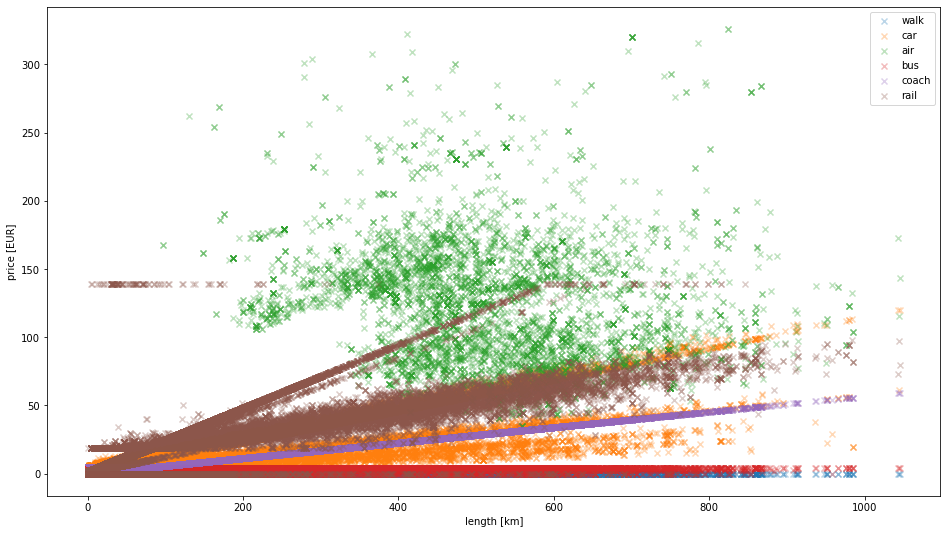

In [72]:
if manual:
    modes = [#('rail_long', 2), ('rail_short', 1),
             ('rail',1), ('coach',3), ('bus',4), ('air',5), ('car',6), ('walk',7)]
    fig, ax = plt.subplots(figsize=(16,9))
    for m, i in modes[::-1]:
        t = trips#.loc[trips['mode_model']==i].copy()
        plt.scatter(t['length'], t['cost_'+m], marker='x', alpha=.3, label=m)
    plt.legend()
    ax.set_xlabel('length [km]')
    ax.set_ylabel('price [EUR]')

## Save calibration dataset

In [73]:
trips.drop(['length_routed', 'distance_routed_2'], axis=1, errors='ignore', inplace=True)

In [74]:
assert len(trips.loc[trips.isna().any(axis=1)])==0

,origin,destination,SKTYP,distance,distance_routed,duration,purpose,mode,mode_combo,n_persons,...,time_road,cost_walk,cost_car,cost_rail_short,cost_rail_long,cost_rail,cost_bus,cost_coach,cost_road,cost_air


In [75]:
trips.to_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')